### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [3]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [4]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(10, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [5]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [6]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [8]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,21
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


### Plot kumulatif

Take initial varian plus "J"

In [9]:
df_J = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "J"].copy()
df_J

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
150,2021-02-15,INDO ISA,JL SEPAKU LAUT,MARGA SARI,BALIKPAPAN BARAT,PEREMPUAN,1989-06-10,Wiraswasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,JM0,J,INDIVIDU,35
414,2021-04-26,SENSILIA NONA ANITA,JL SOEKARNO HATTA KM 9,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1983-02-10,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMB,J,INDIVIDU,42
449,2021-05-05,ZULKHAIDIR,JL.WOLTER MONGINSIDI,BARU ULU,BALIKPAPAN BARAT,LAKI-LAKI,1975-08-03,LAIN-LAIN,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMB,J,INDIVIDU,49
576,2021-06-11,ABDUL RACHMAN,VILLA DAMAI PERMAI,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1967-05-13,Pegawai Swasta-Perdagangan,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JM0,J,INDIVIDU,57
623,2021-06-25,PRESTIYONO,JL MULAWARMAN MANGGAR INDAH,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,1999-08-15,MAHASISWA/PELAJAR,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JN0,J,INDIVIDU,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6073,2024-04-30,AHMAD EKSAN,BALIKPAPAN REGENCY,SEPINGGAN BARU,BALIKPAPAN SELATAN,LAKI-LAKI,1989-08-31,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,JMG,J,INDIVIDU,35
6176,2024-05-15,MOHAMMAD RISWAN,JL MAYOR POL ZAINAL ARIFIN,SUMBER REJO,BALIKPAPAN TENGAH,LAKI-LAKI,1995-08-13,Pegawai Swasta-Pertambangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,JM1,J,INDIVIDU,29
6374,2024-06-12,WATI KASWATI,JL. GIRI REJO II,KARANG JOANG,BALIKPAPAN UTARA,PEREMPUAN,1985-12-21,IBU RUMAH TANGGA,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,JMH,J,INDIVIDU,39
6534,2024-07-16,SUGENG PRIYONO,JL PRONA III PERUM BUKIT PRONA INDAH,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1980-09-02,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,JS0,J,INDIVIDU,44


Plot data initial varian plus "J"

In [10]:
df_J_count = df_J[["Tgl. Mohon"]].copy()
df_J_count["count"] = 1.
df_J_count = df_J_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_J_count["cumulative_sum"] = df_J_count["count"].cumsum()
df_J_count

,Tgl. Mohon,count,cumulative_sum
0,2021-02-15,1,1
1,2021-04-26,1,2
2,2021-05-05,1,3
3,2021-06-11,1,4
4,2021-06-25,1,5
...,...,...,...
75,2024-04-30,1,80
76,2024-05-15,1,81
77,2024-06-12,1,82
78,2024-07-16,1,83


Groub by weekly

In [11]:
df_J_weekly = df_J_count[["Tgl. Mohon"]].copy()
df_J_count["Tgl. Mohon"] = pd.to_datetime(df_J_count["Tgl. Mohon"])

df_J_weekly = (df_J.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_J_weekly["cumulative_sum"] = df_J_weekly["count"].cumsum()
df_J_weekly


,Tgl. Mohon,count,cumulative_sum
0,2021-02-15,1,1
1,2021-02-22,0,1
2,2021-03-01,0,1
3,2021-03-08,0,1
4,2021-03-15,0,1
...,...,...,...
181,2024-08-05,0,83
182,2024-08-12,0,83
183,2024-08-19,0,83
184,2024-08-26,0,83


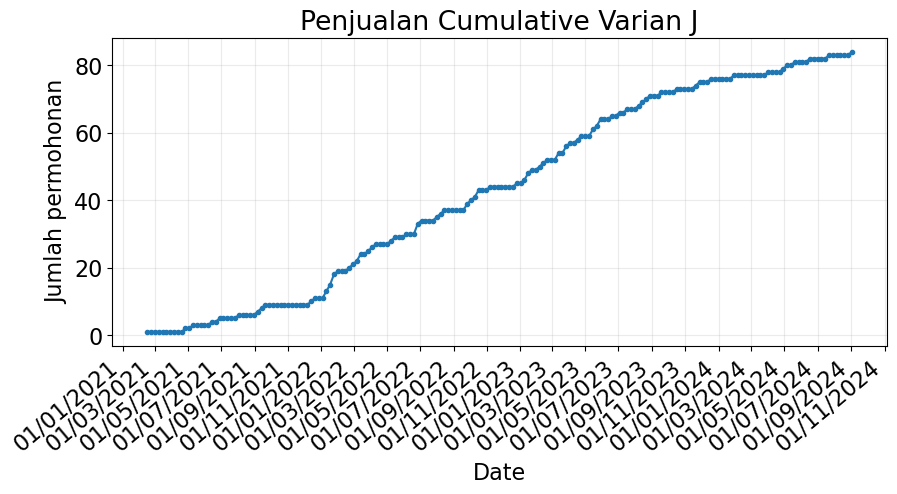

In [12]:
plot_time_series(df_J_weekly["Tgl. Mohon"], df_J_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian J",
                xlabel="Date", ylabel="Jumlah permohonan")

In [13]:
ADF_result = adfuller(df_J_count["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -0.06806884202784595
p-value: 0.9525275777134233


In [ ]:
# ADF_result = adfuller(df_E_weekly["cumulative_sum"])
# print(f"ADF statistic: {ADF_result[0]}")
# print(F"p-value: {ADF_result[1]}")

fisrt diff (_d_=1)

In [14]:
J_diff = np.diff(df_J_count["cumulative_sum"], n=1)
ADF_result = adfuller(J_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -7.048118731522005
p-value: 5.617436477616631e-10


In [ ]:
# E_diff = np.diff(df_E_weekly["cumulative_sum"], n=1)
# ADF_result = adfuller(E_diff)
# print(f"ADF statistic: {ADF_result[0]}")
# print(F"p-value: {ADF_result[1]}")

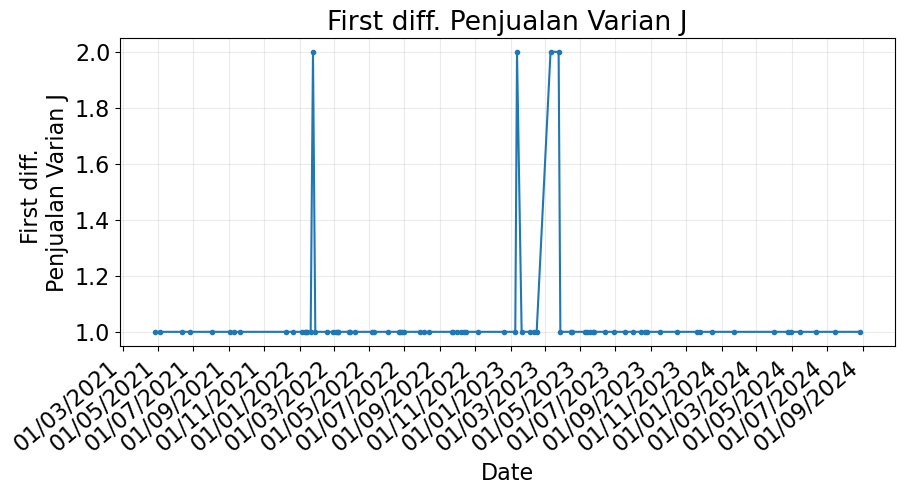

In [15]:
plot_time_series(df_J_count["Tgl. Mohon"].iloc[1:], J_diff, 
                 title="First diff. Penjualan Varian J",
                 xlabel="Date", ylabel="First diff. \nPenjualan Varian J")

In [ ]:
# plot_time_series(df_E_weekly["Tgl. Mohon"].iloc[1:], E_diff, 
#                  title="First diff. Penjualan Varian E",
#                  xlabel="Date", ylabel="Jumlah Permohonan")

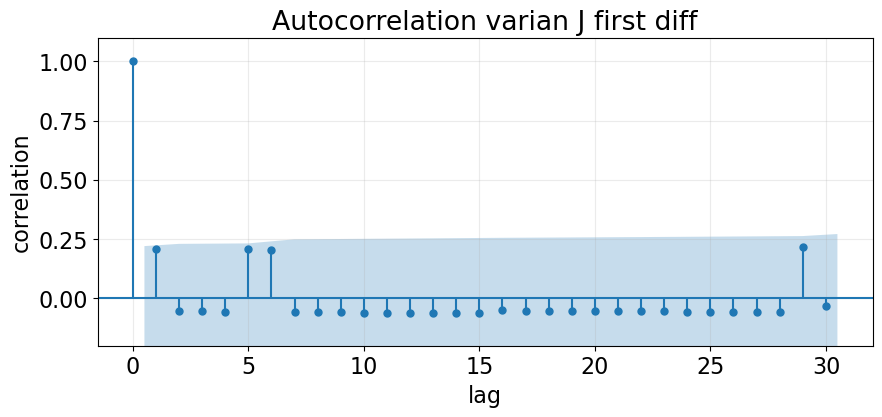

In [17]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(J_diff, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian J first diff")
ax.grid("on")

plt.show(fig)

MA(0)

In [ ]:
# fig, ax = plt.subplots(figsize=(10, 4))

# fig = plot_acf(G_diff, lags=30, ax=ax)

# ax.set_ylim([-.2, 1.1])
# ax.set_ylabel("correlation")
# ax.set_xlabel("lag")
# ax.set_title("Autocorrelation varian E first diff")
# ax.grid("on")

# plt.show(fig)

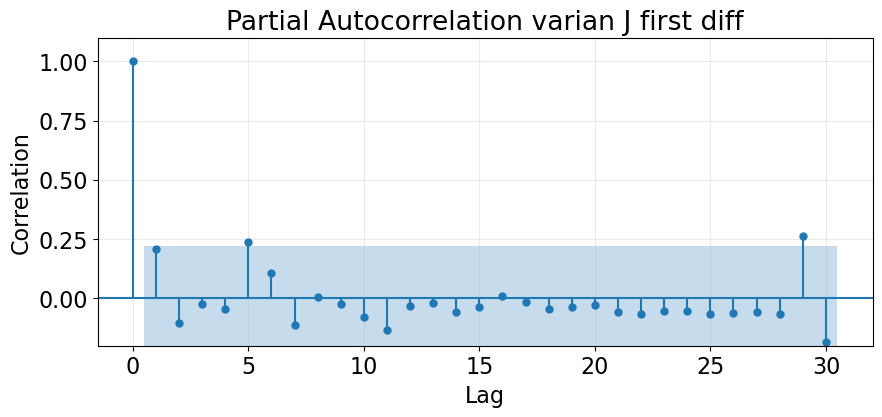

In [18]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_pacf(J_diff, lags=30, ax=ax)

ax.set_ylim([-0.2, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian J first diff")
ax.grid("on")

plt.show()

gaada lag yang signifikan pada acf dan pacf = random walk